<a href="https://colab.research.google.com/github/Ckaur012/Ckaur012/blob/main/potato_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Import all the Dependencies** 


In [19]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

**Set all the Constants**

In [20]:
batch_size = 32
image_size = 256
channels = 3
epochs = 30

**Import data into tensorflow dataset object**

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [21]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/Potato Disease', seed = 123,
                                                              shuffle = True, image_size=(image_size,image_size), batch_size= batch_size)

Found 2152 files belonging to 3 classes.


In [22]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [23]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

**Visualize some of the images from our dataset**

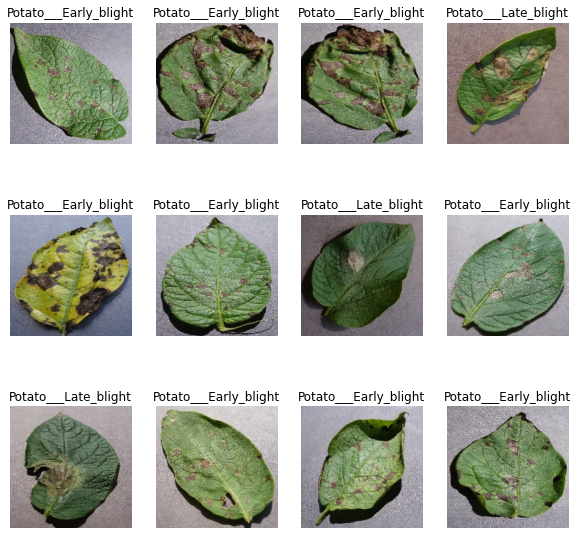

In [24]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
      ax = plt.subplot(3,4, i+1)
      plt.imshow(image_batch[i].numpy().astype('uint8'))
      plt.title(class_names[label_batch[i]])
      plt.axis('off')


**Function to Split Dataset**

Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training
Validation: Dataset to be tested against while training
Test: Dataset to be tested against after we trained a model

In [25]:
len(dataset)

68

In [26]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [27]:
train_data = dataset.take(54)
len(train_data)

54

In [28]:
test_data = dataset.skip(54)
len(test_data)

14

In [29]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [30]:
val_data = test_data.take(6)
len(val_data)

6

In [31]:
test_data = test_data.skip(6)
len(test_data)

8

In [32]:
def train_test_split(data, train_split= 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size= 1000):
  assert  (train_split + val_split + test_split == 1)
  data_size = len(data)
  if shuffle :
    data = data.shuffle(shuffle_size, seed=32)
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    
    train_data = data.take(train_size)    
    val_data = data.skip(train_size).take(val_size)
    test_data = data.skip(train_size).skip(val_size)
    
    return train_data, val_data, test_data

In [33]:
train_ds, val_ds, test_ds = train_test_split(dataset)

In [34]:
len(train_data)

54

In [35]:
len(val_data)

6

In [36]:
len(test_data)

8

**Cache, Shuffle, and Prefetch the Dataset**

In [37]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

***Building the Model***

**Creating a Layer for Resizing and Normalization**

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [38]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size, image_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

**Data Augmentation**

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [39]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

**Applying Data Augmentation to Train Dataset**

In [40]:
train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Model Architecture**

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN**

In [41]:
input_shape = (batch_size, image_size,image_size, channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

**Compiling the Model**

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [43]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [44]:
history = model.fit(train_data,batch_size=batch_size, validation_data=val_data, verbose=1, epochs=30)

Epoch 1/30
54/54 [==============================] - 381s 5s/step - loss: 0.9347 - accuracy: 0.4745 - val_loss: 0.8816 - val_accuracy: 0.4792
Epoch 2/30
54/54 [==============================] - 229s 4s/step - loss: 0.8022 - accuracy: 0.5926 - val_loss: 0.5940 - val_accuracy: 0.7188
Epoch 3/30
54/54 [==============================] - 229s 4s/step - loss: 0.5343 - accuracy: 0.7581 - val_loss: 0.4051 - val_accuracy: 0.8177
Epoch 4/30
54/54 [==============================] - 225s 4s/step - loss: 0.4237 - accuracy: 0.8142 - val_loss: 0.3572 - val_accuracy: 0.8958
Epoch 5/30
54/54 [==============================] - 228s 4s/step - loss: 0.3337 - accuracy: 0.8652 - val_loss: 0.2408 - val_accuracy: 0.9271
Epoch 6/30
54/54 [==============================] - 222s 4s/step - loss: 0.3212 - accuracy: 0.8698 - val_loss: 0.3410 - val_accuracy: 0.8958
Epoch 7/30
54/54 [==============================] - 217s 4s/step - loss: 0.2500 - accuracy: 0.8993 - val_loss: 0.2293 - val_accuracy: 0.9219
Epoch 8/30
54

In [46]:
scores = model.evaluate(test_data)

8/8 [==============================] - 9s 971ms/step - loss: 0.2278 - accuracy: 0.9310


In [47]:
scores

[0.22777268290519714, 0.931034505367279]

***Plotting the Accuracy and Loss Curves***

In [49]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

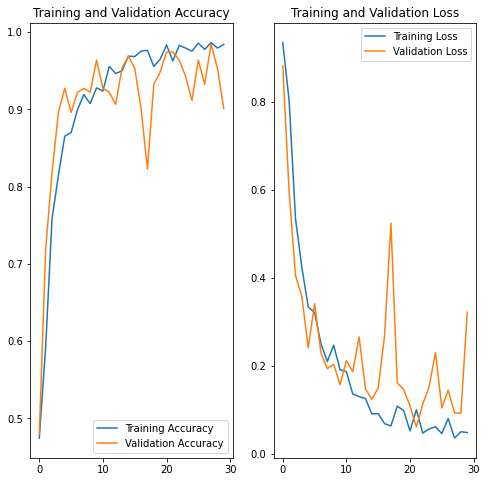

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Run prediction on a sample image**

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 659ms/step
predicted label: Potato___Late_blight


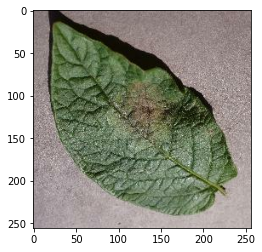

In [55]:
import numpy as np

for image_batch, label_batch in test_data.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print('actual label:', class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**Write a function for inference**

In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 55ms/step


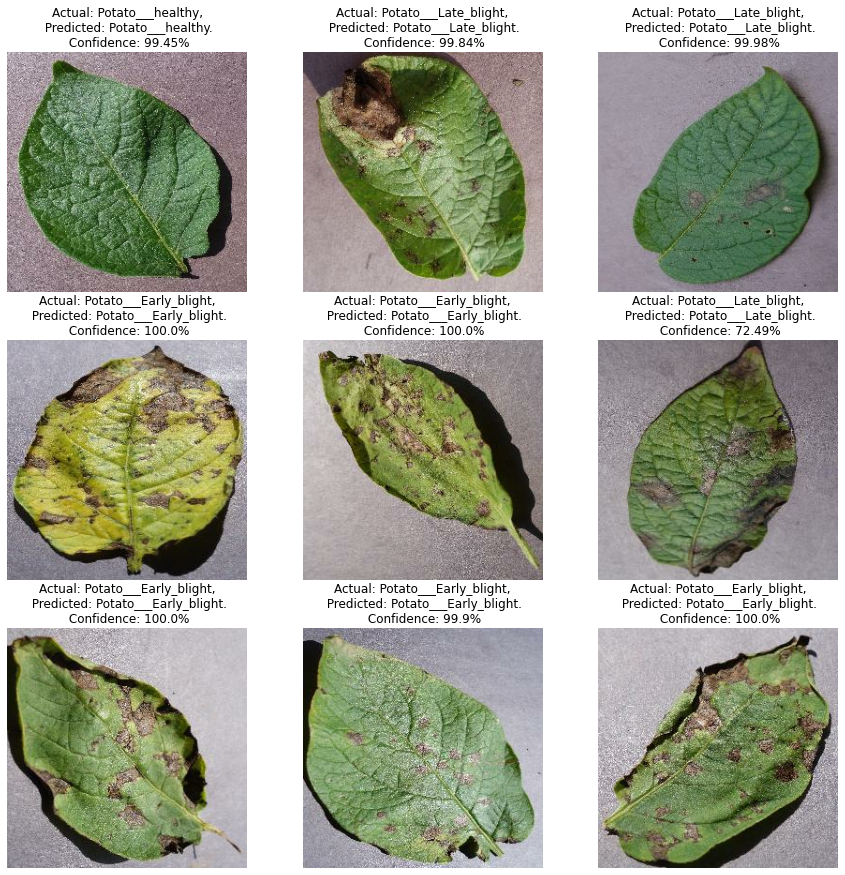

In [63]:
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

**Saving the Model**

We append the model to the list of models as a new version

In [66]:
import os
model_version=max([int(i) for i in os.listdir('/content/drive/MyDrive/Potato Disease/Models') + [0]])+1
model.save(f'/content/drive/MyDrive/Potato Disease/Models/{model_version}')